# Week 11 Part 2: Machine Learning

You will use this notebook to answer questions from the machine learning portion of in the Week 11 quiz.

# ABCD-ReproNim: Exploring machine learning concepts

In this notebook, we will explore some concepts presented in [ABCD-ReproNim lecture 11b](https://youtu.be/LAddDaqUe0A):
- ordering of imputation and scaling in cross-validation
- effect of sample size on error distributions
- ensembling
- evaluation of estimators

You will use this notebook to guide you in answering questions for this week's quiz. First let's import all of the libraries that we will need.

In [1]:
import matplotlib.gridspec as gridspec  # For customizing plot layout
import matplotlib.pyplot as plt  # For making plots to visualize our results
import numpy as np  # For working with array data
import pandas as pd  # For organizing results into dataframes
import seaborn as sns  # For plotting
import time  # For rudimentary executing timing

from scipy.constants import golden_ratio  # For scaling the aspect ratio of our figures

from sklearn.datasets import make_classification  # For generating a synthetic classification problem
from sklearn.impute import KNNImputer  # For imputing missing values in our synthetic dataset
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate  # For splitting our data
from sklearn.model_selection import LeaveOneGroupOut, RepeatedKFold, StratifiedKFold  # For splitting our data
from sklearn.svm import SVC  # Support vector machine classifier
from sklearn.metrics import accuracy_score  # To calculate...wait for it...the accuracy score
from sklearn.ensemble import AdaBoostRegressor  # For exploring the concept of ensembling
from sklearn.tree import DecisionTreeRegressor  # For exploring the concept of ensembling

from nilearn import datasets  # For exploring the Haxby dataset mentioned in the lecture
from nilearn.image import get_data  # See above comment
from nilearn.image import index_img  # See above comment
from nilearn.decoding import Decoder  # I could do this all day

We'll set a random seed for re-executability. Let's choose a random state in honor of NDA Study 901. Can you figure out which study that is?

In [2]:
RANDOM_STATE=901

## Question #6: When should we do data imputation and scaling?

In this problem, we will create a synthetic classification problem using scikit-learn's `make_classification` function and then train a support vector classifier. Real-world datasets often have missing data so we will simulate this by randomly inserting NaN values into our feature matrix. We will also split our dataset into train and test splits, evaluating our model on test data that it did not see during training. So we have several steps in our analysis pipeline (intentionally out of order):

- evaluate model
- split dataset into train and test splits
- impute missing values
- create dataset (including missing values)
- train the model

Some orderings of these steps aren't even possible (e.g. you can't split the data before you create it). But some are both possible and wrong. In the next two cells, we will repeat our analysis with two possible orderings of these steps and report the accuracy scores. Think about these two options and the lecture to answer question #6 in the quiz.

#### Option A: impute then split

In [3]:
# define dataset
X, y = make_classification(
    n_samples=1000,
    n_features=100,
    n_informative=20,
    n_redundant=0,
    n_repeated=0,
    random_state=RANDOM_STATE,
    flip_y=0.2,
)

# Choose random indexes to put NaN values into the data
n_nans = int(X.size * 0.02)
rng = np.random.default_rng(seed=RANDOM_STATE)
index_nan = rng.choice(X.size, n_nans, replace=False)
  
# Add the NaN values to the feature matrix.
X.ravel()[index_nan] = np.nan 

# Impute the missing values
imputer = KNNImputer()
X = imputer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

# Fit the model
model = SVC()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
# evaluate predictions
accuracy_1 = accuracy_score(y_test, y_pred)
print(f"With imputation before splitting, the accuracy {accuracy_1 * 100:4.1f}%.")

With imputation before splitting, the accuracy 82.4%.


#### Option B: Split then impute

In [4]:
# define dataset
X, y = make_classification(
    n_samples=1000,
    n_features=100,
    n_informative=20,
    n_redundant=0,
    n_repeated=0,
    random_state=RANDOM_STATE,
    flip_y=0.1,
)

# Add the NaN values to the feature matrix.
X.ravel()[index_nan] = np.nan 

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

# Impute the missing values
imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# fit the model
model = SVC()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
# evaluate predictions
accuracy_2 = accuracy_score(y_test, y_pred)
print(f"With imputation before splitting, the accuracy score is {accuracy_2 * 100:4.1f}%.")

With imputation before splitting, the accuracy score is 80.6%.



## Question #7: Sample size affects test error distribution

In this section, we are going to create more synthetic classification problems and evaluate `SVC` estimators on them. This time, we will vary the sample size and observe the effect on the test error distribution. Let's first write a function that will create the synthetic dataset and evaluate an `SVC` model on it using [stratified K-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold). We will use the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) function to easily obtain test scores across all of the folds.

In [5]:
def get_svc_crossval_scores(n_samples=50, random_state=RANDOM_STATE):
    # define dataset
    X, y = make_classification(
        n_samples=n_samples,
        n_features=100,
        n_informative=20,
        n_redundant=0,
        n_repeated=0,
        random_state=random_state,
        flip_y=0.1,
    )

    cv = StratifiedKFold(n_splits=20, random_state=RANDOM_STATE, shuffle=True)
    scores = cross_val_score(SVC(), X, y, cv=cv)
    
    return scores

Next, let get scores for a range of sample sizes. This will take a minute or so.

In [6]:
n_samples = [50, 100, 500, 1000, 5000]
sample_scores = {
    n_samp: get_svc_crossval_scores(n_samples=n_samp)
    for n_samp in n_samples
}

Now we'll convert these scores to a pandas DataFrame (because seaborn likes pandas DataFrames) and center the scores by subtracting the mean of each column.

In [7]:
df_scores = pd.DataFrame(sample_scores)
# df_scores = df_scores - df_scores.mean()

And we'll make a plot to look at the distribution of test accuracies. You'll use this plot to answer a question in the quiz.

C:\Users\kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


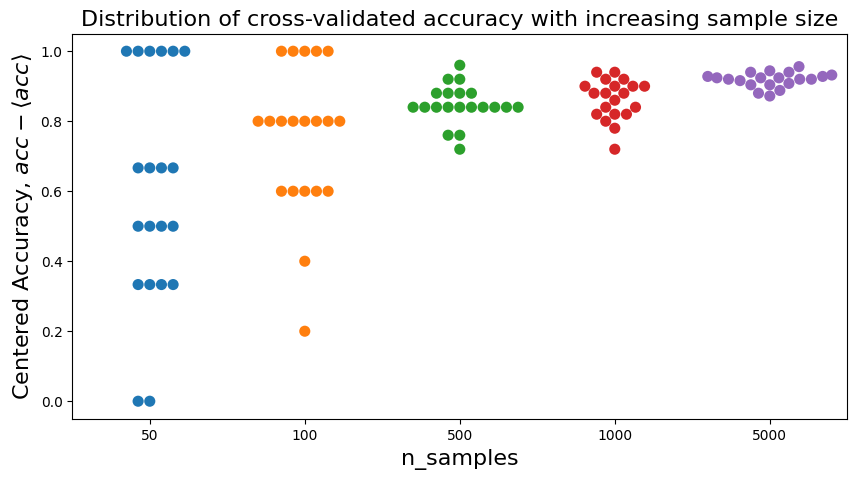

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = sns.swarmplot(data=df_scores, ax=ax, size=8)
_ = ax.set_xlabel("n_samples", fontsize=16)
_ = ax.set_ylabel(r"Centered Accuracy, $acc - \langle acc \rangle$", fontsize=16)
_ = ax.set_title("Distribution of cross-validated accuracy with increasing sample size", fontsize=16)

## Questions #8 and #9: Evaluating different estimators on the Haxby dataset

This section borrows heavily from [a nilearn example](https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_different_estimators.html#sphx-glr-auto-examples-02-decoding-plot-haxby-different-estimators-py) that compares different classifiers in a visual object recognition decoding task. It has some minor modifications for plotting. Run these cells and then reflect on the output as you answer the corresponding quiz question.


In [9]:
# We start by loading data using nilearn dataset fetcher
# by default 2nd subject data will be fetched
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

# load labels
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']

# identify resting state (baseline) labels in order to be able to remove them
resting_state = (stimuli == 'rest')

# extract the indices of the images corresponding to some condition or task
task_mask = np.logical_not(resting_state)

# find names of remaining active labels
categories = stimuli[task_mask].unique()

# extract tags indicating to which acquisition run a tag belongs
session_labels = labels['chunks'][task_mask]


# Load the fMRI data
# For decoding, standardizing is often very important
mask_filename = haxby_dataset.mask_vt[0]
func_filename = haxby_dataset.func[0]

# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily.
fmri_niimgs = index_img(func_filename, task_mask)
classification_target = stimuli[task_mask]


Dataset created in C:\Users\kyle/nilearn_data\haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 273596416 of 291168628 bytes (94.0%,    0.3s remaining) ...done. (5 seconds, 0 min)
Extracting data from C:\Users\kyle/nilearn_data\haxby2001\0a7df7e6986f9ca94043f4c67ae3792a\subj2-2010.01.14.tar.gz..... done.


First subject anatomical nifti image (3D) located is at: C:\Users\kyle/nilearn_data\haxby2001\subj2\anat.nii.gz
First subject functional nifti image (4D) is located at: C:\Users\kyle/nilearn_data\haxby2001\subj2\bold.nii.gz


In [ ]:
# Then we define the various classifiers that we use
classifiers = ['svc_l2', 'svc_l1', 'logistic_l1',
               'logistic_l2', 'ridge_classifier']

# Here we compute prediction scores and run time for all these
# classifiers
cv = LeaveOneGroupOut()
classifiers_data = {}

for classifier_name in sorted(classifiers):
    classifiers_data[classifier_name] = {}
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = Decoder(estimator=classifier_name, mask=mask_filename,
                      standardize=True, cv=cv)
    t0 = time.time()
    decoder.fit(fmri_niimgs, classification_target, groups=session_labels)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_
    classifiers_data[classifier_name]['map'] = decoder.coef_img_['house']

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for category in categories:
        print("    %14s vs all -- AUC: %1.2f +- %1.2f" % (
            category,
            np.mean(classifiers_data[classifier_name]['score'][category]),
            np.std(classifiers_data[classifier_name]['score'][category]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores

______________________________________________________________________


C:\Users\kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\image\resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


logistic_l1: 39.33s
          scissors vs all -- AUC: 0.00 +- 0.00
              face vs all -- AUC: 0.17 +- 0.37
               cat vs all -- AUC: 0.45 +- 0.46
              shoe vs all -- AUC: 0.00 +- 0.00
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.99 +- 0.01
            bottle vs all -- AUC: 0.16 +- 0.35
             chair vs all -- AUC: 0.00 +- 0.00
______________________________________________________________________


C:\Users\kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\image\resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


logistic_l2: 125.23s
          scissors vs all -- AUC: 0.90 +- 0.08
              face vs all -- AUC: 0.97 +- 0.04
               cat vs all -- AUC: 0.97 +- 0.04
              shoe vs all -- AUC: 0.91 +- 0.08
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.97 +- 0.08
            bottle vs all -- AUC: 0.82 +- 0.17
             chair vs all -- AUC: 0.87 +- 0.17
______________________________________________________________________


C:\Users\kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\image\resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


ridge_classifier: 45.01s
          scissors vs all -- AUC: 0.94 +- 0.05
              face vs all -- AUC: 0.98 +- 0.02
               cat vs all -- AUC: 0.95 +- 0.04
              shoe vs all -- AUC: 0.94 +- 0.07
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 1.00 +- 0.00
            bottle vs all -- AUC: 0.89 +- 0.09
             chair vs all -- AUC: 0.93 +- 0.07
______________________________________________________________________


C:\Users\kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\image\resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


    svc_l1: 14.95s
          scissors vs all -- AUC: 0.92 +- 0.05
              face vs all -- AUC: 0.98 +- 0.03
               cat vs all -- AUC: 0.96 +- 0.04
              shoe vs all -- AUC: 0.92 +- 0.07
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.99 +- 0.01
            bottle vs all -- AUC: 0.89 +- 0.08
             chair vs all -- AUC: 0.93 +- 0.04
______________________________________________________________________


C:\Users\kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\image\resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Aside: Note here we use the procedural interface to matplotlib
as opposed to the object-oriented interfaces used above.
Both of them work. The procedural interface is fast and very Matlab-like.
The object-oriented interface can be more expressive if you want fine-grained control over what your plots look like.

In [ ]:
plt.figure(figsize=(8, 8))

all_categories = np.sort(np.hstack([categories, 'AVERAGE']))
tick_position = np.arange(len(all_categories))
plt.yticks(tick_position + 0.25, all_categories)
height = 0.12

cmap = plt.get_cmap("tab10").colors
for i, (color, classifier_name) in enumerate(zip(cmap ,classifiers)):
    score_means = [
        np.mean(classifiers_data[classifier_name]['score'][category])
        for category in all_categories
    ]

    plt.barh(tick_position, score_means,
             label=classifier_name.replace('_', ' '),
             height=height, color=color)
    tick_position = tick_position + height

plt.xlabel('Classification accuracy (AUC score)')
plt.ylabel('Visual stimuli category')
plt.xlim(xmin=0.5, xmax=1.0)
plt.legend(loc='lower left', ncol=1, bbox_to_anchor=(0.9, 0.0))
plt.title(
    'Category-specific classification accuracy for different classifiers')
plt.tight_layout()

## Question #10: Introduction to ensembling

Dr. Varaquaux discussed the FREM model in his lecture, which is an ensemble approach. In this question, we will explore an ensemble method called [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost). We will train three models on a sinusoidal dataset:

- A simple decision tree (with `max_depth = 4`)
- A complex decision tree (with `max_depth = 15`)
- An ensemble of 300 simple decision trees (each with `max_depth = 4`)

We will then plot each model's prediction as well as it's performance on train and test sets.

In [ ]:
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 150)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.25, X.shape[0])

# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = DecisionTreeRegressor(max_depth=15)
regr_3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)



Use [`RepeatedKFold`](https://scikit-learn.org/stable/modules/cross_validation.html#repeated-k-fold) to generate more model performance data.

In [ ]:


cv = RepeatedKFold(n_splits=10, n_repeats=10)
cv_scores_1 = cross_validate(regr_1, X, y, cv=cv, return_train_score=True)
cv_scores_2 = cross_validate(regr_2, X, y, cv=cv, return_train_score=True)
cv_scores_3 = cross_validate(regr_3, X, y, cv=cv, return_train_score=True)

Store the train and test scores in separate dataframes. We will [`melt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html) the DataFrames so that each model type is a different entry in the model column.

In [ ]:
df_train_scores = pd.DataFrame({
    "Simple Tree": cv_scores_1["train_score"],
    "Complex Tree": cv_scores_2["train_score"],
    "Ensemble": cv_scores_3["train_score"],
}).melt(var_name="model")
df_test_scores = pd.DataFrame({
    "Simple Tree": cv_scores_1["test_score"],
    "Complex Tree": cv_scores_2["test_score"],
    "Ensemble": cv_scores_3["test_score"],
}).melt(var_name="model")

Now plot the true function as well as the three estimates. Also plot the train and test set performance distributions.

In [ ]:
fig_height = 7
fig_width = golden_ratio * fig_height
fontsize=14
fig = plt.figure(tight_layout=True, figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

_ = sns.swarmplot(data=df_train_scores, x="model", y="value", size=3, ax=ax1)
_ = sns.swarmplot(data=df_test_scores, x="model", y="value", size=4, ax=ax2)

_ = ax1.set_title("Cross-validated training scores", fontsize=fontsize)
_ = ax2.set_title("Cross-validated test scores", fontsize=fontsize)

for ax in [ax1, ax2]:
    ax.set_ylabel(r"$R^2$ score", fontsize=fontsize)
    ax.set_xlabel("")
    ax.tick_params(axis="x", which="major", labelsize=fontsize)

# Plot the results
ax0.scatter(X, y, c="k", alpha=0.8, label="training samples")
ax0.plot(X, y_1, c="g", ls="-.", alpha=0.8, label="Simple tree", linewidth=2)
ax0.plot(X, y_2, c="r", ls="--", alpha=0.8, label="Complex tree", linewidth=2)
ax0.plot(X, y_3, c="b", ls="-.", alpha=0.8, label="Simple tree ensemble", linewidth=2)
ax0.set_xlabel("data", fontsize=fontsize)
ax0.set_ylabel("target", fontsize=fontsize)
ax0.set_title("Boosted Decision Tree Regression", fontsize=fontsize)
_ = ax0.legend()

You will use these plots to answer a question in this week's quiz. This example shows why ensemble learning is a popular strategy to address the bias-variance tradeoff (see [this example for a more detailed discussion of bias/variance in ensemble learning](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)). Ensembling is also the inspiration for the [FREM pipeline](https://nilearn.github.io/decoding/frem.html) that Dr. Varoquaux mentioned in the lecture. See [this nilearn example](https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_frem.html#sphx-glr-auto-examples-02-decoding-plot-haxby-frem-py) to use FREM on the Haxby dataset that you saw earlier.